## WITH ZZ COUPLING TO TLS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, tensor, sigmaz, sigmax, sigmam, sigmam, mesolve, identity
from qtt.algorithms.functions import gauss_ramsey, fit_gauss_ramsey, plot_gauss_ramsey_fit
from scipy.optimize import curve_fit
from typing import Dict, Tuple, List

In [ ]:
𝑆
(
𝑡
)
=
𝐴
⋅
𝑒
−
𝑡
/
𝑇
2
∗
⋅
cos
⁡
(
2
𝜋
𝑓
𝑡
+
𝜙
)
+
𝐶
where:

𝐴
 is the amplitude,

𝑇
2
∗
 is the coherence time,

𝑓
 is the frequency,

𝜙
 is the phase,

𝐶
 is an offset.

In [5]:
# Define the Ramsey function
def ramsey(t, A, T2_star, f, phi, C):
    return A * np.exp(-t/T2_star) * np.cos(2*np.pi*f*t + phi) + C

# Fitting function for T1 decay
def exp_decay(t, a, T1, c):
    return a * np.exp(-t / T1) + c

# Convert <σ> to |1⟩ population
def make_population(expect):
    pop = (1 + expect) / 2  
    return pop

In [6]:
def setup_operators(system_params: Dict[str, any])  \
        -> Tuple[np.ndarray, List[np.ndarray], np.ndarray, np.ndarray]:
    """
    Setup Hamiltonian and collapse operators for the system.

    Args:
        system_params (Dict[str, any]): Dictionary containing system parameters.

    Returns:
        Tuple[np.ndarray, List[np.ndarray], np.ndarray, np.ndarray]: 
        Hamiltonian, list of collapse operators, and measurement operators for 
        qubits.
    """
    sz_q1 = tensor(sigmaz(), identity(2), identity(2))
    sz_q2 = tensor(identity(2), sigmaz(), identity(2))
    sz_tls = tensor(identity(2), identity(2), sigmaz())

    sm_q1 = tensor(sigmam(), identity(2), identity(2))
    sm_q2 = tensor(identity(2), sigmam(), identity(2))
    sm_tls = tensor(identity(2), identity(2), sigmam())

    # for later use
    sx_q1 = tensor(sigmax(), identity(2), identity(2))
    sx_q2 = tensor(identity(2), sigmax(), identity(2))

    H_Q1 = 2 * np.pi * system_params["fq1"] / 2 * sz_q1
    H_Q2 = 2 * np.pi * system_params["fq2"] / 2 * sz_q2
    H_TLS = 2 * np.pi * system_params["fTLS"] / 2 * sz_tls
    H_ZZ = 2 * np.pi * system_params["Jzz"] * sz_q1 * sz_q2
    H_Q1_TLS = 2 * np.pi * system_params["J_TLS"] * sz_q1 * sz_tls

    H = H_Q1 + H_Q2 + H_ZZ + H_TLS + H_Q1_TLS

    c_ops = [
        np.sqrt(system_params["relaxation"]["q1"]) * sm_q1,
        np.sqrt(system_params["dephasing"]["q1"] / 2) * sz_q1,
        np.sqrt(system_params["relaxation"]["q2"]) * sm_q2,
        np.sqrt(system_params["dephasing"]["q2"] / 2) * sz_q2,
        np.sqrt(system_params["relaxation"]["TLS"]) * sm_tls,
        np.sqrt(system_params["dephasing"]["TLS"] / 2) * sz_tls,
    ]

    return H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2

# No Coupling Case

In [35]:
# Define system parameters
SYSTEM_PARAMS_NOCOUP = {
    "fq1": 3.2,  # GHz, Qubit 1 frequency
    "fq2": 3.35,  # GHz, Qubit 2 frequency
    "fTLS": 3.2,  # GHz, TLS frequency (resonant with Qubit 1)
    "J_TLS": 0.05,  # Coupling strength between Qubit 1 and TLS
    "relaxation": {"q1": 1/20, "q2": 1/25, "TLS": 1/5},  # Relaxation rates
    "dephasing": {"q1": 1/15, "q2": 1/18, "TLS": 1/3},  # Dephasing rates
    "Jzz": 0.0, # Jzz coupling
    "time_points": np.linspace(0, 30, 100)  # Time points in μs
}

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS_NOCOUP)

# get times
tlist = SYSTEM_PARAMS_NOCOUP["time_points"]

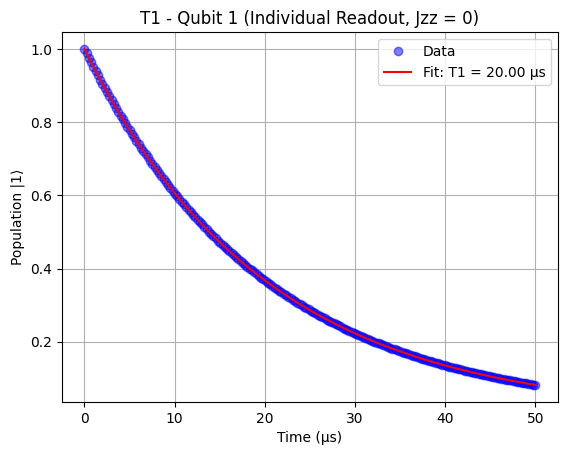

In [30]:
# T1 measurement for Qubit 1 
psi0 = tensor(basis(2, 0), basis(2, 1), basis(2, 1))  # |0⟩|1⟩|1⟩

# solve LME in z basis
result = mesolve(H, psi0, tlist, c_ops, e_ops=[sz_q1])

# convert to population 
pop = make_population(result.expect[0])

# fit results
popt, _ = curve_fit(exp_decay, tlist, pop, p0=[1.0, 20, 0])
T1 = popt[1]

# draw 
# Create a figure and axes object
fig, ax = plt.subplots()

ax.plot(tlist, pop, 'bo', alpha=0.5, label='Data')
ax.plot(tlist, exp_decay(tlist, *popt), 'r-', 
         label=f'Fit: T1 = {T1:.2f} μs')
ax.set_title('T1 - Qubit 1 (Individual Readout, Jzz = 0)')
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Population |1⟩')
ax.legend()
ax.grid(True)

ax_q1_t1_ind = ax 

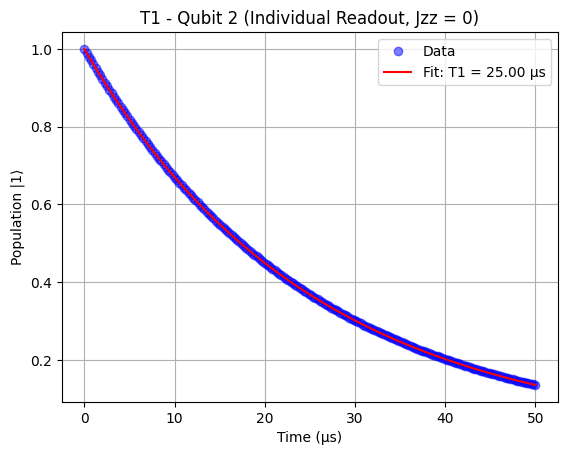

In [ ]:
# T1 measurement for Qubit 2 
psi0 = tensor(basis(2, 1), basis(2, 0), basis(2, 1))  # |1⟩|0⟩|1⟩

# solve LME in z basis
result = mesolve(H, psi0, tlist, c_ops, e_ops=[sz_q2])

# convert to population 
pop = make_population(result.expect[0])

# fit results
popt, _ = curve_fit(exp_decay, tlist, pop, p0=[1.0, 20, 0])
T1 = popt[1]

# draw 
# Create a figure and axes object
fig, ax = plt.subplots()

ax.plot(tlist, pop, 'bo', alpha=0.5, label='Data')
ax.plot(tlist, exp_decay(tlist, *popt), 'r-', 
         label=f'Fit: T1 = {T1:.2f} μs')
ax.set_title('T1 - Qubit 2 (Individual Readout, Jzz = 0)')
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Population |1⟩')
ax.legend()
ax.grid(True)

ax_q2_t1_ind = ax 

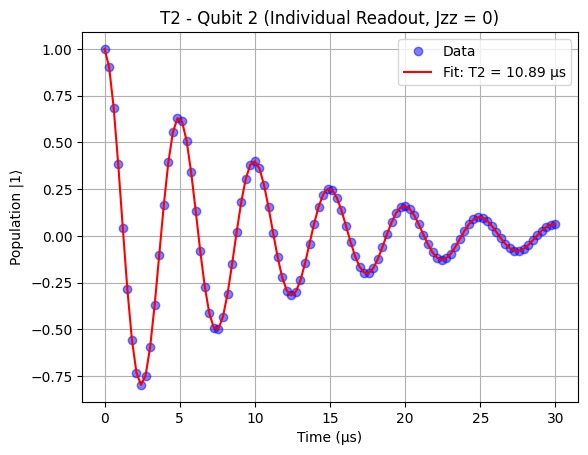

In [ ]:
# T2 measurement for Qubit 1 
psi0 = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2, 1), basis(2, 1))  # |+⟩|1⟩|1⟩

# solve LME in z basis
result = mesolve(H, psi0, tlist, c_ops, e_ops=[sx_q1])

# convert to population 
pop = make_population(result.expect[0])
#pop = (result.expect[0])

# fit results
fit_parameters, _ = fit_gauss_ramsey(tlist, pop)
popt, _ = curve_fit(ramsey, tlist, pop, p0=fit_parameters)
T2 = popt[1]

# draw 
# Create a figure and axes object
fig, ax = plt.subplots()

ax.plot(tlist, pop, 'bo', alpha=0.5, label='Data')
ax.plot(tlist, ramsey(tlist, *popt), 'r-', 
         label=f'Fit: T2 = {T2:.2f} μs')

ax.set_title('T2 - Qubit 2 (Individual Readout, Jzz = 0)')
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Population |1⟩')
ax.legend()
ax.grid(True)

ax_q2_t2_ind = ax 

In [ ]:
# 1. Individual Readout (Jzz = 0)
# T2 for Qubit 1 (individual)
psi0_q1_t2_ind = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2, 0), basis(2, 0))  # |+⟩|0⟩|0⟩
result_q1_t2_ind = mesolve(H_ind, psi0_q1_t2_ind, tlist, c_ops_ind, [sx_q1_ind])
coherence_q1_ind = np.abs(result_q1_t2_ind.expect[0])

# Fit T2 for Qubit 1 (individual)
popt_q1_t2_ind, _ = curve_fit(exp_decay, tlist, coherence_q1_ind, p0=[1.0, 15, 0])
T2_q1_ind = popt_q1_t2_ind[1]


In [31]:
# T1 measurement for Qubit 1 (individual)
psi0_q1_ind = tensor(basis(2, 1), basis(2, 0), basis(2, 0))  # |1⟩|0⟩|0⟩
result_q1_t1_ind = mesolve(H_ind, psi0_q1_ind, tlist, c_ops_ind, [sz_q1_ind])
pop_q1_ind = (1 - result_q1_t1_ind.expect[0]) / 2  # Convert <σz> to |1⟩ population

# Fit T1 for Qubit 1 (individual)
popt_q1_t1_ind, _ = curve_fit(exp_decay, tlist, pop_q1_ind, p0=[1.0, 20, 0])
T1_q1_ind = popt_q1_t1_ind[1]

# T1 measurement for Qubit 2 (individual)
psi0_q2_ind = tensor(basis(2, 0), basis(2, 1), basis(2, 0))  # |0⟩|1⟩|0⟩
result_q2_t1_ind = mesolve(H_ind, psi0_q2_ind, tlist, c_ops_ind, [sz_q2_ind])
pop_q2_ind = (1 - result_q2_t1_ind.expect[0]) / 2  # Convert <σz> to |1⟩ population

# Fit T1 for Qubit 2 (individual)
popt_q2_t1_ind, _ = curve_fit(exp_decay, tlist, pop_q2_ind, p0=[1.0, 25, 0])
T1_q2_ind = popt_q2_t1_ind[1]

# 2. Multiplexed Readout (Jzz ≠ 0)
H_mult, c_ops_mult, sz_q1_mult, sz_q2_mult, sx_q1_mult, sx_q2_mult, sm_q1_mult, sm_q2_mult = setup_operators(use_zz_coupling=True)

# T1 measurement for Qubit 1 (multiplexed)
psi0_q1_mult = tensor(basis(2, 1), basis(2, 0), basis(2, 0))  # |1⟩|0⟩|0⟩
result_q1_t1_mult = mesolve(H_mult, psi0_q1_mult, tlist, c_ops_mult, [sz_q1_mult])
pop_q1_mult = (1 - result_q1_t1_mult.expect[0]) / 2

# Fit T1 for Qubit 1 (multiplexed)
popt_q1_t1_mult, _ = curve_fit(exp_decay, tlist, pop_q1_mult, p0=[1.0, 20, 0])
T1_q1_mult = popt_q1_t1_mult[1]

# T1 measurement for Qubit 2 (multiplexed)
psi0_q2_mult = tensor(basis(2, 0), basis(2, 1), basis(2, 0))  # |0⟩|1⟩|0⟩
result_q2_t1_mult = mesolve(H_mult, psi0_q2_mult, tlist, c_ops_mult, [sz_q2_mult])
pop_q2_mult = (1 - result_q2_t1_mult.expect[0]) / 2

# Fit T1 for Qubit 2 (multiplexed)
popt_q2_t1_mult, _ = curve_fit(exp_decay, tlist, pop_q2_mult, p0=[1.0, 25, 0])
T1_q2_mult = popt_q2_t1_mult[1]

# --- T2 MEASUREMENTS ---

# 1. Individual Readout (Jzz = 0)
# T2 for Qubit 1 (individual)
psi0_q1_t2_ind = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2, 0), basis(2, 0))  # |+⟩|0⟩|0⟩
result_q1_t2_ind = mesolve(H_ind, psi0_q1_t2_ind, tlist, c_ops_ind, [sx_q1_ind])
coherence_q1_ind = np.abs(result_q1_t2_ind.expect[0])

# Fit T2 for Qubit 1 (individual)
popt_q1_t2_ind, _ = curve_fit(exp_decay, tlist, coherence_q1_ind, p0=[1.0, 15, 0])
T2_q1_ind = popt_q1_t2_ind[1]

# T2 for Qubit 2 (individual)
psi0_q2_t2_ind = tensor(basis(2, 0), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 0))  # |0⟩|+⟩|0⟩
result_q2_t2_ind = mesolve(H_ind, psi0_q2_t2_ind, tlist, c_ops_ind, [sx_q2_ind])
coherence_q2_ind = np.abs(result_q2_t2_ind.expect[0])

# Fit T2 for Qubit 2 (individual)
popt_q2_t2_ind, _ = curve_fit(exp_decay, tlist, coherence_q2_ind, p0=[1.0, 18, 0])
T2_q2_ind = popt_q2_t2_ind[1]

# 2. Multiplexed Readout (Jzz ≠ 0)
# T2 for Qubit 1 (multiplexed)
psi0_q1_t2_mult = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2, 0), basis(2, 0))  # |+⟩|0⟩|0⟩
result_q1_t2_mult = mesolve(H_mult, psi0_q1_t2_mult, tlist, c_ops_mult, [sx_q1_mult])
coherence_q1_mult = np.abs(result_q1_t2_mult.expect[0])

# Fit T2 for Qubit 1 (multiplexed)
popt_q1_t2_mult, _ = curve_fit(exp_decay, tlist, coherence_q1_mult, p0=[1.0, 15, 0])
T2_q1_mult = popt_q1_t2_mult[1]

# T2 for Qubit 2 (multiplexed)
psi0_q2_t2_mult = tensor(basis(2, 0), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 0))  # |0⟩|+⟩|0⟩
result_q2_t2_mult = mesolve(H_mult, psi0_q2_t2_mult, tlist, c_ops_mult, [sx_q2_mult])
coherence_q2_mult = np.abs(result_q2_t2_mult.expect[0])

# Fit T2 for Qubit 2 (multiplexed)
popt_q2_t2_mult, _ = curve_fit(exp_decay, tlist, coherence_q2_mult, p0=[1.0, 18, 0])
T2_q2_mult = popt_q2_t2_mult[1]

# --- PLOTTING T1 RESULTS ---
plt.figure(figsize=(15, 10))

# Plot 1: T1 for Qubit 1 (Individual)
plt.subplot(2, 2, 1)
plt.plot(tlist, pop_q1_ind, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q1_t1_ind), 'r-', 
         label=f'Fit: T1 = {T1_q1_ind:.2f} μs')
plt.title('T1 - Qubit 1 (Individual Readout, Jzz = 0)')
plt.xlabel('Time (μs)')
plt.ylabel('Population |1⟩')
plt.legend()
plt.grid(True)

# Plot 2: T1 for Qubit 2 (Individual)
plt.subplot(2, 2, 2)
plt.plot(tlist, pop_q2_ind, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q2_t1_ind), 'r-', 
         label=f'Fit: T1 = {T1_q2_ind:.2f} μs')
plt.title('T1 - Qubit 2 (Individual Readout, Jzz = 0)')
plt.xlabel('Time (μs)')
plt.ylabel('Population |1⟩')
plt.legend()
plt.grid(True)

# Plot 3: T1 for Qubit 1 (Multiplexed)
plt.subplot(2, 2, 3)
plt.plot(tlist, pop_q1_mult, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q1_t1_mult), 'r-', 
         label=f'Fit: T1 = {T1_q1_mult:.2f} μs')
plt.title('T1 - Qubit 1 (Multiplexed Readout, Jzz = 0.01)')
plt.xlabel('Time (μs)')
plt.ylabel('Population |1⟩')
plt.legend()
plt.grid(True)

# Plot 4: T1 for Qubit 2 (Multiplexed)
plt.subplot(2, 2, 4)
plt.plot(tlist, pop_q2_mult, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q2_t1_mult), 'r-', 
         label=f'Fit: T1 = {T1_q2_mult:.2f} μs')
plt.title('T1 - Qubit 2 (Multiplexed Readout, Jzz = 0.01)')
plt.xlabel('Time (μs)')
plt.ylabel('Population |1⟩')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('T1_plots.png')
plt.show()

# --- PLOTTING T2 RESULTS ---
plt.figure(figsize=(15, 10))

# Plot 1: T2 for Qubit 1 (Individual)
plt.subplot(2, 2, 1)
plt.plot(tlist, coherence_q1_ind, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q1_t2_ind), 'r-', 
         label=f'Fit: T2 = {T2_q1_ind:.2f} μs')
plt.title('T2 - Qubit 1 (Individual Readout, Jzz = 0)')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence |⟨σx⟩|')
plt.legend()
plt.grid(True)

# Plot 2: T2 for Qubit 2 (Individual)
plt.subplot(2, 2, 2)
plt.plot(tlist, coherence_q2_ind, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q2_t2_ind), 'r-', 
         label=f'Fit: T2 = {T2_q2_ind:.2f} μs')
plt.title('T2 - Qubit 2 (Individual Readout, Jzz = 0)')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence |⟨σx⟩|')
plt.legend()
plt.grid(True)

# Plot 3: T2 for Qubit 1 (Multiplexed)
plt.subplot(2, 2, 3)
plt.plot(tlist, coherence_q1_mult, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q1_t2_mult), 'r-', 
         label=f'Fit: T2 = {T2_q1_mult:.2f} μs')
plt.title('T2 - Qubit 1 (Multiplexed Readout, Jzz = 0.01)')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence |⟨σx⟩|')
plt.legend()
plt.grid(True)

# Plot 4: T2 for Qubit 2 (Multiplexed)
plt.subplot(2, 2, 4)
plt.plot(tlist, coherence_q2_mult, 'bo', alpha=0.5, label='Data')
plt.plot(tlist, exp_decay(tlist, *popt_q2_t2_mult), 'r-', 
         label=f'Fit: T2 = {T2_q2_mult:.2f} μs')
plt.title('T2 - Qubit 2 (Multiplexed Readout, Jzz = 0.01)')
plt.xlabel('Time (μs)')
plt.ylabel('Coherence |⟨σx⟩|')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('T2_plots.png')
plt.show()

# Print results
print("T1 Measurements:")
print("----------------")
print("Individual Readout (Jzz = 0):")
print(f"Qubit 1: T1 = {T1_q1_ind:.2f} μs")
print(f"Qubit 2: T1 = {T1_q2_ind:.2f} μs")

print("\nMultiplexed Readout (Jzz = 0.01):")
print(f"Qubit 1: T1 = {T1_q1_mult:.2f} μs")
print(f"Qubit 2: T1 = {T1_q2_mult:.2f} μs")

print("\nT2 Measurements:")
print("----------------")
print("Individual Readout (Jzz = 0):")
print(f"Qubit 1: T2 = {T2_q1_ind:.2f} μs")
print(f"Qubit 2: T2 = {T2_q2_ind:.2f} μs")

print("\nMultiplexed Readout (Jzz = 0.01):")
print(f"Qubit 1: T2 = {T2_q1_mult:.2f} μs")
print(f"Qubit 2: T2 = {T2_q2_mult:.2f} μs")


NameError: name 'H_ind' is not defined

In [15]:
spin0 = basis(2,0)

print("spin0:")
print(spin0)

print("sigmam * spin0")
print(sigmam()*spin0)

spin0:
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]
sigmam * spin0
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]]


In [16]:
spin1 = basis(2,1)

print("spin1:")
print(spin1)

print("sigmam * spin1")
print(sigmam()*spin1)

spin1:
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]]
sigmam * spin1
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]]
